Up-to-date version: https://colab.research.google.com/drive/124gIEjgF0HXOObG33R4rbpCyb5CLQ8UT

# Opening the black box of deep learning

Naftali Tishby and Ravid Schwartz-Ziv investigated the information flow in deep learning in their paper [Opening the black box of Deep Neural Networks via Information, 2017](https://arxiv.org/abs/1703.00810). They argued, the learning process of a neural network with the stochastic gradient descend undergoes two phases - fitting and compression. During the first phase, a model "overfits" the training data and accumulates the data entropy / variability. During the second phase, a model forgets redundant entropy of the input data, finds the descriptive statistics and compresses data representation.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSWvffYjQblJpgvKlpb8JT3yUpbPrEniFun0gvdco-974ClwvrAnw)

In this tutorial we'll examine these two phases on MNIST and CIFAR10 datasets in PyTorch.


In [0]:
# install required packages
%matplotlib inline
!pip install torchvision==0.2.1 matplotlib==3.0.1 scikit-learn==0.20.0 numpy==1.15.4 pillow==4.1.1

    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 12.9MB 2.6MB/s 
    100% |████████████████████████████████| 5.3MB 1.1MB/s 
    100% |████████████████████████████████| 13.9MB 2.9MB/s 
    100% |████████████████████████████████| 5.7MB 3.7MB/s 
    100% |████████████████████████████████| 519.5MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58fea000 @  0x7fc12d9322a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 952kB 4.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Foun

Processing...
Done!


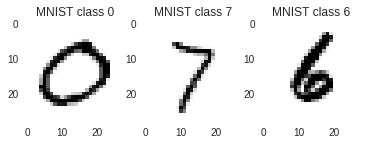

In [0]:
from collections import namedtuple, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
import torch
import torch.nn as nn
import torch.utils.data
from torchvision import transforms, datasets

torch.random.manual_seed(26)
np.random.seed(26)

DATA_DIR = 'data'
BATCH_SIZE = 256

DatasetInfo = namedtuple("DatsetInfo", ('class_', 'image_size', 'mean', 'std'))

DATASET_INFO = {
    "MNIST": DatasetInfo(class_=datasets.MNIST, image_size=28, mean=[0.1307], std=[0.1932]),
    "CIFAR10": DatasetInfo(class_=datasets.CIFAR10, image_size=32, mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
}


def torch_to_matplotlib(image):
    if image.shape[0] == 1:
        return image.squeeze(dim=0)
    else:
        return image.transpose(0, 1).transpose(1, 2)


def get_data_loader(dataset_str: str, train=True, normalize=True, shuffle=True):
    dataset_info = DATASET_INFO[dataset_str]
    transform = [transforms.ToTensor()]
    if normalize:
        transform.append(transforms.Normalize(mean=dataset_info.mean, std=dataset_info.std))
    dataset = dataset_info.class_(DATA_DIR, train=train, download=True, transform=transforms.Compose(transform))
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=0)
    return loader


def visualize(dataset_str: str):
    loader = get_data_loader(dataset_str, normalize=False)
    images, labels = next(iter(loader))
    for im_id in range(3):
        plt.subplot(1, 3, im_id + 1)
        image = torch_to_matplotlib(images[im_id])
        plt.imshow(image)
        plt.title(f"{loader.dataset.__class__.__name__} class {labels[im_id]}")
        plt.grid(False)


visualize("MNIST")
# visualize("CIFAR10")


## Training

Now we add minimum code to train a multi layer perceptron.

In [0]:
class MLP(nn.Module):

    def __init__(self, *fc_sizes: int):
        """
        :param fc_sizes: fully-connected layer sizes
        """
        super().__init__()
        fc_sizes = list(fc_sizes)
        n_classes = fc_sizes.pop()
        classifier = []
        for in_features, out_features in zip(fc_sizes[:-1], fc_sizes[1:]):
            linear = nn.Linear(in_features=in_features, out_features=out_features)
            classifier.append(linear)
            classifier.append(nn.ReLU(inplace=True))
        classifier.append(nn.Linear(in_features=fc_sizes[-1], out_features=n_classes))
        self.classifier = nn.Sequential(*classifier)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x


def full_forward_pass(model: nn.Module, loader: torch.utils.data.DataLoader):
    use_cuda = torch.cuda.is_available()
    outputs_full = []
    labels_full = []
    with torch.no_grad():
        for inputs, labels in iter(loader):
            if use_cuda:
                inputs = inputs.cuda()
            outputs = model(inputs)
            outputs_full.append(outputs.cpu())
            labels_full.append(labels)
    outputs_full = torch.cat(outputs_full, dim=0)
    labels_full = torch.cat(labels_full, dim=0)
    return outputs_full, labels_full


def calc_accuracy(labels_true, labels_predicted) -> float:
    accuracy = (labels_true == labels_predicted).type(torch.float32).mean()
    return accuracy.item()


class Trainer:

    def __init__(self, model: nn.Module, dataset_str: str):
        if torch.cuda.is_available():
            model = model.cuda()
        self.model = model
        self.train_loader = get_data_loader(dataset_str, train=True)
        self.eval_loader = get_data_loader(dataset_str, train=True, shuffle=False)
        self.test_loader = get_data_loader(dataset_str, train=False)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        print(f"Total batches: {len(self.train_loader)}")

    def forward_pass_train(self):
        outputs_train, labels_train = full_forward_pass(self.model, self.eval_loader)
        return outputs_train, labels_train

    def batch_finished(self, epoch, batch_id):
        pass

    def train(self, n_epochs=10):
        accuracy_train = []
        accuracy_test = []
        loss_train = []
        use_cuda = torch.cuda.is_available()
        print(f"Training {self.model}")
        for epoch in range(1, n_epochs+1):
            for batch_id, (images, labels) in enumerate(iter(self.train_loader)):
                if use_cuda:
                    images = images.cuda()
                    labels = labels.cuda()
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step(closure=None)
                self.batch_finished(epoch, batch_id)
            outputs_train, labels_train = self.forward_pass_train()
            outputs_test, labels_test = full_forward_pass(self.model, self.test_loader)
            loss_train.append(self.criterion(outputs_train, labels_train).item())
            accuracy_train.append(calc_accuracy(labels_train, labels_predicted=outputs_train.argmax(dim=1)))
            accuracy_test.append(calc_accuracy(labels_test, labels_predicted=outputs_test.argmax(dim=1)))
            print(f"Epoch {epoch}: Accuracy train={accuracy_train[-1]:.3f}, test={accuracy_test[-1]:.3f}; "
                  f"Loss={loss_train[-1]:.3f}")
            
            plt.clf()
            plt.subplot(121)
            plt.plot(range(epoch), accuracy_train, label='train', marker='o')
            plt.plot(range(epoch), accuracy_test, label='test', marker='o')
            plt.legend()
            plt.title("Accuracy")
            plt.xlabel("Epoch")
            plt.subplot(122)
            plt.plot(range(epoch), loss_train, marker='o')
            plt.title("Train loss")
            plt.xlabel("Epoch")


# Trainer(model=MLP(784, 128, 10), dataset_str="MNIST").train(n_epochs=5)

Now we want to analyze what happens with the information as it flows from layer to layer. To compute the information between high dimensional continuous vectors, we must bin the activations with the precision defined by us.

## Binning

The size of activation vector in a neural network changes from layer to layer. How do you compute the mutual information $I(X_{[784]}; T_{[128]})$ in a batch of B samples between the input $X$ and the hidden layer $T$ in a fully connected MLP 784 -> 128 -> 10?

The classical way to compute mutual information is to place semantically similar data in one bin. Data realizations can can be either scalars (e.g., predicted class labels) or vectors (layer activations). To maximize the mutual information, estimated from the binned realizations, to the true unknown mutual information between $X_{[784]}$ and $T_{[128]}$, _maximum entropy binning_ is used: each bin has the same number of data realizations. In this case, we maximize discrete entropy of $T$ to $H(T)=log_2 N_{bins}$. Then we compute conditional entropy $H(T|X)$ and calculate discrete mutual information from the binned data just like we did in lessons `02.MutualInformation.ipynb` and `03.HabituationSpikes.ipynb`:

$$I(X; T) = H(T) - H(T|X)$$

How do you bin $B$ vectors of length $N$ in $C$ clusters with the maximum entropy principle in mind?

In [0]:
def bin_vectors(vectors: np.ndarray, n_bins: int):
    """
    :param vectors: matrix of shape (#samples, #neurons)
    :param n_bins: number of bins to use
    :return: list of bin indices (between 0 and n_bins-1) of length #samples
    """
    # your code goes here
    return np.random.randint(low=0, high=n_bins, size=len(vectors))

In [0]:
def discrete_entropy(digits) -> float:
    """
    :param digits: realizations of a discrete random variable X
    :return estimated entropy of X in bits
    """
    unique, counts = np.unique(digits, return_counts=True)
    proba = counts / len(digits)
    entropy = sum(proba * np.log2(1 / proba))
    return entropy


def discrete_mutual_information(x, y) -> float:
    """
    :param x: realizations of a discrete random variable X
    :param y: realizations of a discrete random variable Y
    :return: estimated mutual information between X and Y in bits
    """
    entropy_x = discrete_entropy(x)
    entropy_x_given_y = 0
    for y_unique in np.unique(y):
        mask = y == y_unique
        x_given_y = x[mask]
        entropy_x_given_y += discrete_entropy(x_given_y) * np.mean(mask)
    info = entropy_x - entropy_x_given_y
    return info


def find_named_layers(model: nn.Module, layer_class, name_prefix=''):
    for name, layer in model.named_children():
        yield from find_named_layers(layer, layer_class, name_prefix=f"{name_prefix}.{name}")
    if isinstance(model, layer_class):
        yield name_prefix.lstrip('.'), model


class MutualInformation:

    InfoXY = namedtuple("InfoXY", ('info_x', 'info_y'))

    def __init__(self, model: nn.Module, eval_loader, n_bins: int = 20):
        self.model = model
        self.eval_loader = eval_loader
        self.n_bins = n_bins
        self.quantized = {}
        self.information = defaultdict(lambda: self.InfoXY(info_x=[], info_y=[]))
        self.is_active = False
        self.activations = defaultdict(list)
        self.layer_to_name = {}

        self.prepare_input()
        for name, layer in find_named_layers(model, layer_class=(nn.Linear, nn.Conv2d)):
            layer.register_forward_hook(self.save_activations)
            self.layer_to_name[layer] = name

    def __repr__(self):
        return f"{MutualInformation.__name__}(n_bins={self.n_bins})"

    def force_update(self):
        self.start_listening()
        use_cuda = torch.cuda.is_available()
        with torch.no_grad():
            for images, labels in iter(self.eval_loader):
                if use_cuda:
                    images = images.cuda()
                self.model(images)  # outputs of each layer are saved implicitly
        self.finish_listening()

    def start_listening(self):
        self.activations.clear()
        self.is_active = True

    def finish_listening(self):
        self.is_active = False
        for hname in list(self.activations.keys()):
            activations = self.activations.pop(hname)
            activations = torch.cat(activations, dim=0)
            self.quantized[hname] = bin_vectors(vectors=activations.numpy(), n_bins=self.n_bins)
            info_x = discrete_mutual_information(self.quantized['input'], self.quantized[hname])
            info_y = discrete_mutual_information(self.quantized['target'], self.quantized[hname])
            self.information[hname].info_x.append(info_x)
            self.information[hname].info_y.append(info_y)

    def save_activations(self, module: nn.Module, tensor_input, tensor_output):
        if not self.is_active:
            return
        layer_name = self.layer_to_name[module]
        tensor_output_clone = tensor_output.cpu()
        if tensor_output_clone is tensor_output:
            tensor_output_clone = tensor_output_clone.clone()
        tensor_output_clone = tensor_output_clone.flatten(start_dim=1)
        self.activations[layer_name].append(tensor_output_clone)

    def prepare_input(self):
        targets = []
        classifier = sklearn.cluster.MiniBatchKMeans(n_clusters=self.n_bins,
                                                     batch_size=BATCH_SIZE,
                                                     compute_labels=False)
        print("Processing input data. Stage 1 ...")
        for images, labels in iter(self.eval_loader):
            images = images.flatten(start_dim=1)
            classifier.partial_fit(images, labels)
            targets.append(labels)
        targets = torch.cat(targets, dim=0)
        self.quantized['target'] = targets.numpy()

        print("Processing input data. Stage 2 ...")
        centroids_predicted = []
        for images, _ in iter(self.eval_loader):
            images = images.flatten(start_dim=1)
            centroids_predicted.append(classifier.predict(images))
        self.quantized['input'] = np.hstack(centroids_predicted)

    def plot(self):
        plt.clf()
        for layer_name, (info_x, info_y) in self.information.items():
            plt.plot(info_x, info_y, label=layer_name, marker='o')
        plt.title('Mutual information plane')
        plt.xlabel('I(X; T), bits')
        plt.ylabel('I(Y; T), bits')
        plt.legend()
        plt.show()

In [0]:
# Before training a model, let's estimate the mutual information between an 
# output T of a randomly initialized model and a true class Y.
# Think before running the experiment. What value should it take?
mutual_info_estimator = MutualInformation(model=MLP(784, 128, 10), 
                                          eval_loader=get_data_loader(dataset_str="MNIST", shuffle=False), 
                                          n_bins=20)
mutual_info_estimator.force_update()
print(mutual_info_estimator.information)

Processing input data. Stage 1 ...
Processing input data. Stage 2 ...
defaultdict(<function MutualInformation.__init__.<locals>.<lambda> at 0x7f454a967730>, {'classifier.0': InfoXY(info_x=[2.729411019100794], info_y=[1.7763306795690599]), 'classifier.2': InfoXY(info_x=[1.0718721706753955], info_y=[0.7437475071144384])})


And you notice that for a model with randomly initialized weights the mutual information $I(Y; T)$ is nonzero for both layers (`classifier.0` and `classifier.2`). But, clearly, model predictions are random and hence its accuracy is $p={1 \over 10}$ (MNIST has 10 distinct unique digits). You might think this is due to imperfect binning method when we calculate mutual information. Indeed, it biases our estimation, but even if we had an ideal estimator of mutual information, we'd still get nonzero information values. Why?

Hint: do we loose information $I(X; Y)$, if we multiply $X$ by a random weight matrix $W$ $$I(T=W \cdot X; Y) < I(X; Y) \ \ \ ?$$ Data processing inequality tells us that we can only loose information as we process it. But how much? To make the question concrete, weight parameters come from a zero-mean unit-variance normal distribution: $w_{ij} \sim N(0, 1)$. For simplicity, take $W$ as a square matrix $N \times N$, where $N$ is the size of $X$. Then $X$ can be reconstructed from $T$ as $X=W^{-1} \cdot T$. What if $W$ is not a squre matrix? What happens to information if we apply a nonlinear function such as ReLU -- Rectified Linear Unit $relu(x) = max(x, 0)$?

Total batches: 235
Processing input data. Stage 1 ...
Processing input data. Stage 2 ...
MutualInformation(n_bins=20)
Training MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Force update mutual information. Batch 0 / 235


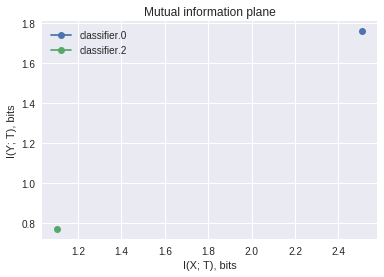

Force update mutual information. Batch 20 / 235


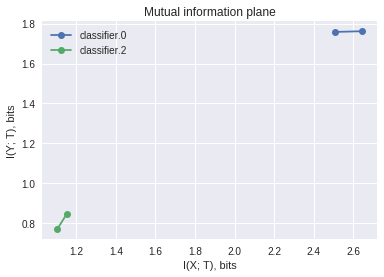

Force update mutual information. Batch 40 / 235


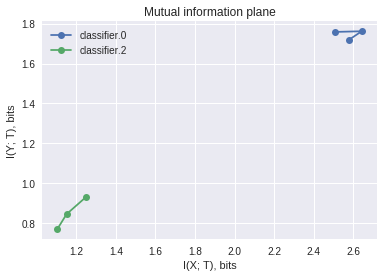

Force update mutual information. Batch 60 / 235


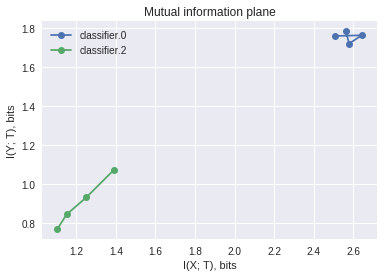

Force update mutual information. Batch 80 / 235


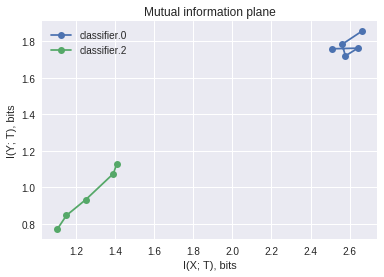

Force update mutual information. Batch 100 / 235


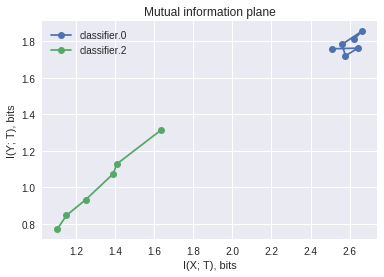

Force update mutual information. Batch 120 / 235


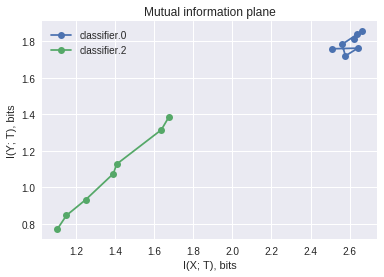

Force update mutual information. Batch 140 / 235


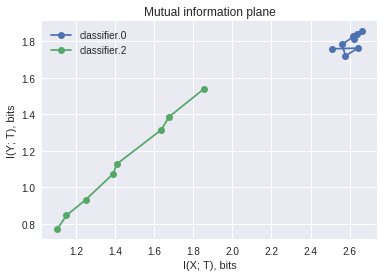

Force update mutual information. Batch 160 / 235


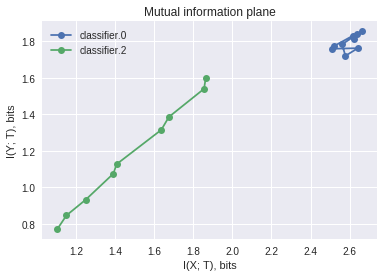

Force update mutual information. Batch 180 / 235


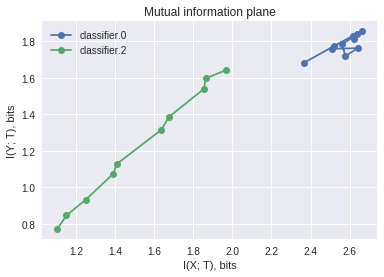

Force update mutual information. Batch 200 / 235


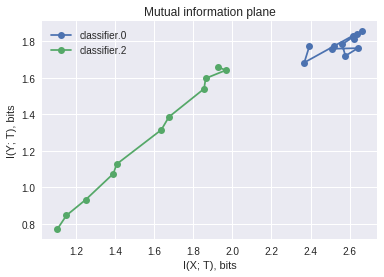

Force update mutual information. Batch 220 / 235


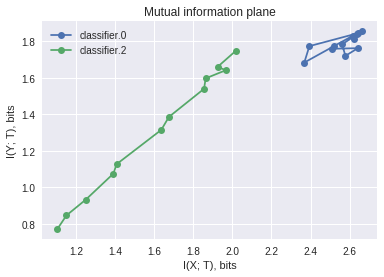

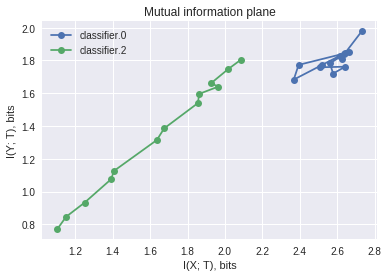

Epoch 1: Accuracy train=0.703, test=0.718; Loss=1.508


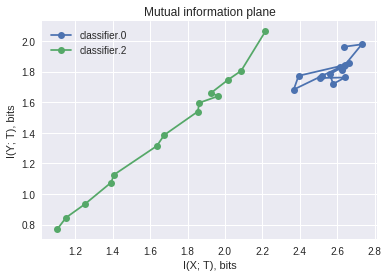

Epoch 2: Accuracy train=0.802, test=0.815; Loss=1.016


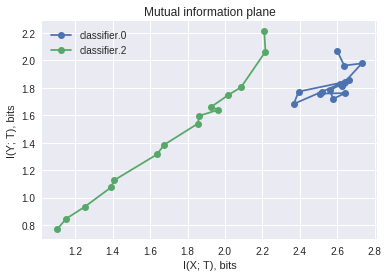

Epoch 3: Accuracy train=0.838, test=0.846; Loss=0.776


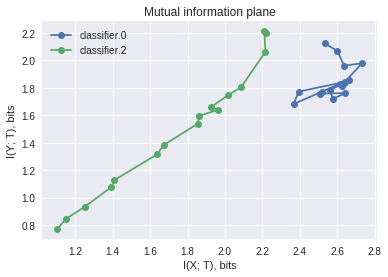

Epoch 4: Accuracy train=0.854, test=0.864; Loss=0.650


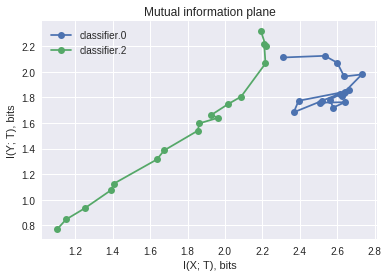

Epoch 5: Accuracy train=0.865, test=0.872; Loss=0.574


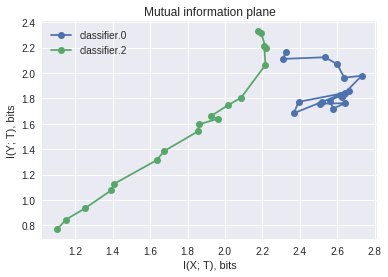

Epoch 6: Accuracy train=0.873, test=0.880; Loss=0.523


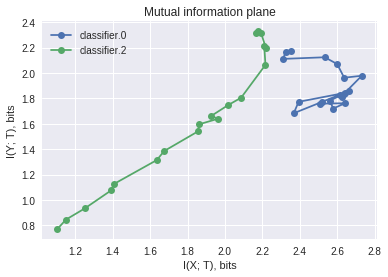

Epoch 7: Accuracy train=0.878, test=0.884; Loss=0.487


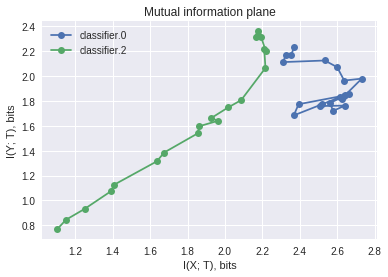

Epoch 8: Accuracy train=0.883, test=0.889; Loss=0.460


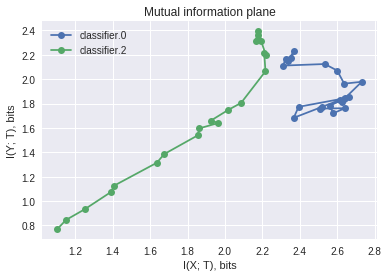

Epoch 9: Accuracy train=0.886, test=0.893; Loss=0.438


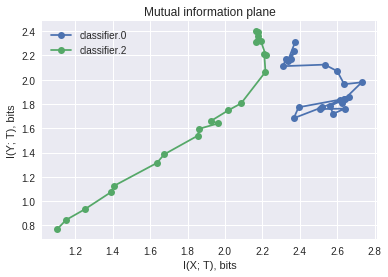

Epoch 10: Accuracy train=0.889, test=0.896; Loss=0.421


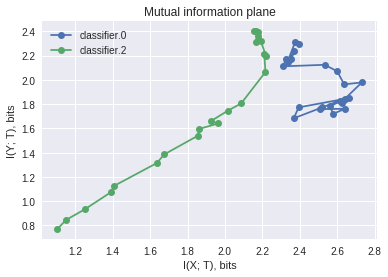

Epoch 11: Accuracy train=0.891, test=0.899; Loss=0.407


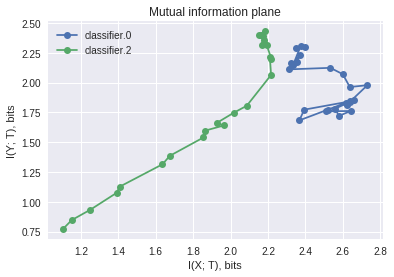

Epoch 12: Accuracy train=0.894, test=0.901; Loss=0.395


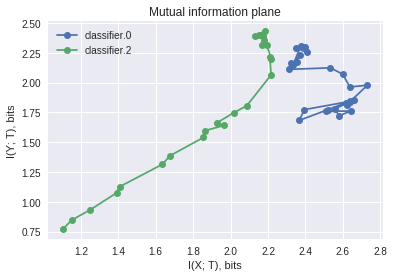

Epoch 13: Accuracy train=0.896, test=0.903; Loss=0.384


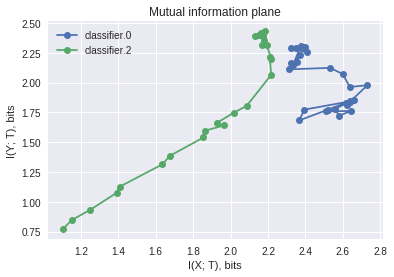

Epoch 14: Accuracy train=0.898, test=0.905; Loss=0.375


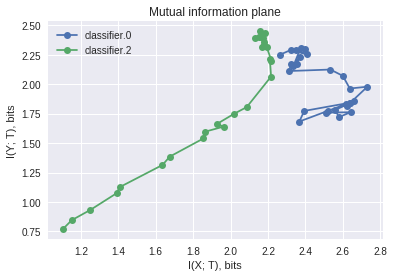

Epoch 15: Accuracy train=0.899, test=0.905; Loss=0.367


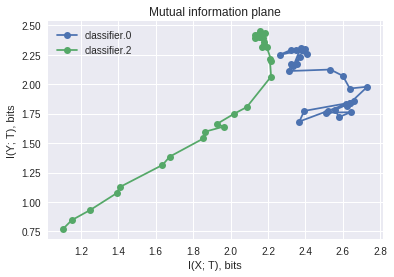

Epoch 16: Accuracy train=0.901, test=0.907; Loss=0.360


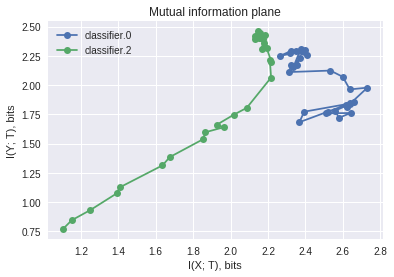

Epoch 17: Accuracy train=0.902, test=0.908; Loss=0.353


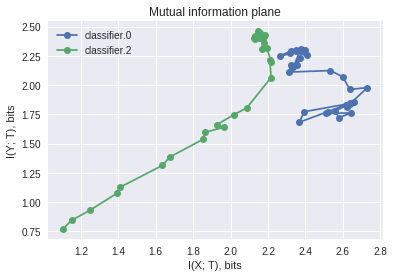

Epoch 18: Accuracy train=0.904, test=0.910; Loss=0.348


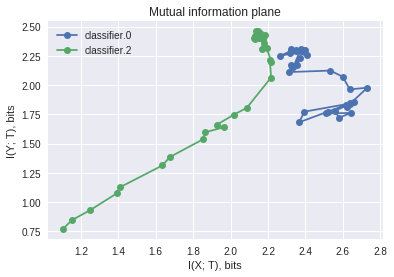

Epoch 19: Accuracy train=0.905, test=0.911; Loss=0.342


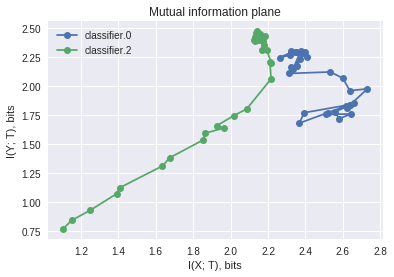

Epoch 20: Accuracy train=0.906, test=0.911; Loss=0.337


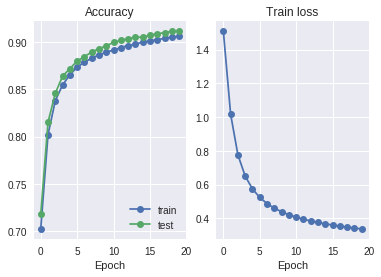

In [0]:
# Now it's time to rock it!

class TrainerInformation(Trainer):

    def __init__(self, model: nn.Module, dataset_str: str):
        super().__init__(model=model, dataset_str=dataset_str)
        self.mutual_info = MutualInformation(model=model, eval_loader=self.eval_loader)
        print(self.mutual_info)

    def forward_pass_train(self):
        self.mutual_info.start_listening()
        outputs_train, labels_train = super().forward_pass_train()
        self.mutual_info.finish_listening()
        self.mutual_info.plot()
        return outputs_train, labels_train

    def batch_finished(self, epoch, batch_id):
        if epoch == 1 and batch_id % 20 == 0:
            print(f"Force update mutual information. Batch {batch_id} / {len(self.train_loader)}")
            self.mutual_info.force_update()
            self.mutual_info.plot()


trainer = TrainerInformation(model=MLP(784, 128, 10), dataset_str='MNIST')
trainer.train(n_epochs=20)

#### Phase transition

When you train a network for 50-100 epochs and look at the information plane, you can see $I(X; T)$ changes its direction while $I(Y; T)$ still continues growing. If you examine Signal to Noise Ratio of parameter gradients (explained in Tishby paper), you may notice that gradients mean and standard deviation become equal at the same moment as $I(X; T)$ changes its direction in the information plane. Tishby claims the model undergoes a *phase transition* at this point. His opponents object his finding - an interesting discussion between the groups of authors and their experimental results you can find at https://openreview.net/forum?id=ry_WPG-A-.

#### Low I(X; T)

It's hard to cluster the input data in, say, 20 bins such that each bin contains equal amount of data (maximum entropy binning). That's why the information between $X$ and hidden layer activations $T$ in the example above is less than 3 bits. Imperfect binning algorithm of high-dimensional images lowers our estimate of $H(X)$ which in turn underestimates $I(X; T)$ *but on the same amount each time*. For the same reason, it's hard to calculate entropy of convolutional layers, unless more sophisticated estimator is used (see "Alternatives to binning" section). Still, we can compare different network architectures on one plot, if we fix the number of bins in all experiments.

## How I(Y; T) relates to accuracy

You might have noticed that the mutual information values of $I(Y; T)$ follow the model accuracy: the higher the accuracy, the more information gain; accuracy drops - and $I(Y; T)$ drops as well. Is there a direct way to estimate model accuracy from the mutual information and vice versa?

Firstly, we assume the training data is well balanced, i.e. all classes have nearly the same amount of samples such that the marginal distribution of the train data $p(y)={1 \over C}$, where $C$ is the number of classes. Then, assuming we shuffle the data which consists of $N \gg C$ points, entropy of $H(Y) \approx log_2 C$. 

Let $T$, hidden layer activations from all data, consists of a set of unique vectors $\{t_i\}_{i=1..|T|}$, $|T| \le N$. Then $H(Y|T)=\sum_t^{|T|} p_T(t)H(Y|T=t)$ and $H(Y|T=t) = \sum_{y=1}^{y=C}p_{model}(y|t)log_2 {1 \over p_{model}(y|t)}$ is the likelihood entropy. At the very beginning of training, $p_{model}(y|t)={1 \over C}$ is a poor estimator of a true unknown class $y$ and we're not interested much in the model accuracy as well as the mutual information. An interesting part becomes when the model has been trained to a some degree $\hat p$ such that, on average, it correctly predicts $\hat p$ times. And we assume that the model prediction distribution $p_{model}(y|t)$ is peaked at the true label class $(p_{model}(y=y_{true}|t)=\hat p)$ and equally distributed among other choices $(p_{model}(y \ne y_{true}|t)=p_{error} < \hat p)$. 

The final assumption is $|T| = C$ which, combined with the previous assumption, means that $T$'s layer activations are equally distributed among $C$ clusters. This is a mild assumption for entropy calculation, based on binning, especially when the network is trained and samples with one label tend to attract to special points in a $T$-space. We say there are at least $C$ such attractors in a $T$-space. It means that $\hat p + p_{error}(C - 1) = 1$. See the illustration below.

With our assumptions in mind, we have 

\begin{array}{lcl} p_{error} & = & {{1 - \hat p} \over {C - 1}} \\ H(Y|T=t) & = & \hat p log_2{1 \over \hat p} + \sum_{y=1}^{y=C-1} p_{error}log_2{1 \over p_{error}} & = & \hat p log_2{1 \over \hat p} + (1 - \hat p)log_2{{C-1} \over {1 - \hat p}} \\ p_T(t) & = & {1 \over C} \\ I(Y; T)& = &H(Y)-H(Y|T)& = &log_2 C - \hat p log_2{1 \over \hat p} - (1 - \hat p)log_2{{C-1} \over {1 - \hat p}} \end{array}

where $\hat p$ is the estimated accuracy.


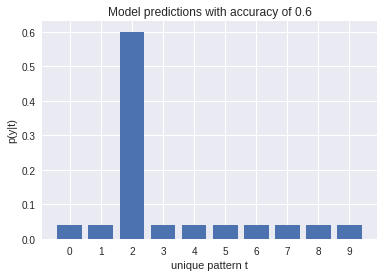

In [0]:
def visualize_balanced_predictor():
    p_hat = 0.6  # model accuracy
    C = 10
    p_predicted = np.full(shape=C, fill_value=(1 - p_hat) / C)
    p_predicted[2] = p_hat  # let assume it was class '2'
    plt.bar(range(C), p_predicted)
    plt.xlabel('unique pattern t')
    plt.xticks(range(C))
    plt.ylabel('p(y|t)')
    plt.title(f'Model predictions with accuracy of {p_hat}')
    plt.show()


visualize_balanced_predictor()

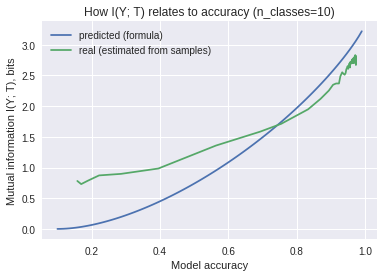

In [0]:
class AccuracyFromMutualInfo:
    def __init__(self, n_classes: int, resolution_bins=100):
        self.n_classes = n_classes
        self.accuracy_binned = np.linspace(start=1 / n_classes, stop=1, num=resolution_bins, endpoint=False)
        entropy_correct = self.accuracy_binned * np.log2(1 / self.accuracy_binned)
        entropy_incorrect = (1 - self.accuracy_binned) * np.log2((n_classes - 1) / (1 - self.accuracy_binned))
        entropy_class_given_activations = entropy_correct + entropy_incorrect
        entropy_classes = np.log2(n_classes)
        self.mutual_info_binned = entropy_classes - entropy_class_given_activations

    def estimate_accuracy(self, mutual_info_bits: float) -> float:
        """
        :param mutual_info_bits: mutual information between the hidden layer T and the true class Y
        :return: estimated layer accuracy
        """
        bin_id = np.digitize(mutual_info_bits, bins=self.mutual_info_binned)
        bin_id = min(bin_id, len(self.accuracy_binned) - 1)
        accuracy_estimated = self.accuracy_binned[bin_id]
        return accuracy_estimated

    def plot(self):
        plt.plot(self.accuracy_binned, self.mutual_info_binned, label='predicted (formula)')
        plt.xlabel('Model accuracy')
        plt.ylabel('Mutual information I(Y; T), bits')
        plt.title(f'How I(Y; T) relates to accuracy (n_classes={self.n_classes})')
        
        
AccuracyFromMutualInfo(n_classes=10).plot()
# add real mutual information, estimated with KMeans on the EmbedderSDR model, defined below
accuracy_real = [0.15828334, 0.16958334, 0.18836667, 0.22194999, 0.28591666,
        0.39535001, 0.56435001, 0.69398332, 0.75526667, 0.83386666,
        0.87035   , 0.89456666, 0.90695   , 0.91578335, 0.92421669,
        0.9282167 , 0.93368334, 0.93746668, 0.94088334, 0.94370002,
        0.94563335, 0.94786668, 0.94964999, 0.95116669, 0.95284998,
        0.95434999, 0.95508331, 0.95628333, 0.95723331, 0.95818335,
        0.95926666, 0.95955002, 0.96041667, 0.96121669, 0.96201664,
        0.96251667, 0.96240002, 0.96366668, 0.96420002, 0.96436667,
        0.96483332, 0.96533334, 0.96546668, 0.96600002, 0.96600002,
        0.96663332, 0.96668333, 0.96665001, 0.96728331, 0.96749997,
        0.96740001, 0.96735001, 0.96789998, 0.96811664, 0.96805   ,
        0.96875   , 0.96826667, 0.96880001, 0.96866667, 0.96925002,
        0.96931666, 0.96908331, 0.96960002, 0.96950001, 0.9702    ,
        0.96976668, 0.96990001, 0.96986669, 0.97001666, 0.97001666,
        0.97036666, 0.9701333 , 0.97070003, 0.97053331, 0.97083336,
        0.97068334, 0.97068334, 0.97098333, 0.97136664, 0.97105002,
        0.97109997, 0.97130001, 0.97163332, 0.97168332, 0.97176665,
        0.97176665, 0.97201669, 0.97221667, 0.97184998, 0.97196668,
        0.97264999, 0.97226667, 0.97266668, 0.97221667, 0.97256666,
        0.9727    , 0.97291666, 0.9727    , 0.97286665, 0.97293335,
        0.97306669, 0.97286665, 0.9727    , 0.97303331, 0.97271669,
        0.97288334, 0.97305   , 0.97334999, 0.97253335, 0.97366667,
        0.97341669, 0.97329998, 0.97315001, 0.97334999, 0.97351664,
        0.97328335, 0.97323334, 0.97376668, 0.97348332, 0.97336668,
        0.97375   , 0.97355002, 0.97334999, 0.97401667, 0.97358334,
        0.97396666, 0.97369999, 0.97334999, 0.97369999, 0.97359997,
        0.97406667, 0.97423333, 0.97381669, 0.97415   , 0.97294998,
        0.97416669, 0.97436666, 0.97418332, 0.97413331, 0.97383332,
        0.97428334, 0.97403336, 0.97439998, 0.97420001 ]
information_real = [0.78085449, 0.72990955, 0.78320148, 0.87143757, 0.89631068,
        0.98354192, 1.35811179, 1.58496849, 1.7121023 , 1.94804225,
        2.1184577 , 2.25299718, 2.34754324, 2.36851204, 2.36875495,
        2.48449286, 2.5510073 , 2.52596204, 2.51066401, 2.53887383,
        2.59721155, 2.62440866, 2.65105915, 2.60647421, 2.65524843,
        2.6767925 , 2.69825669, 2.62840379, 2.71748079, 2.70082141,
        2.70335372, 2.69039601, 2.73106643, 2.70119839, 2.69863454,
        2.75833074, 2.71747513, 2.72547778, 2.73127874, 2.75092291,
        2.70950153, 2.70248041, 2.74676527, 2.71362181, 2.77224625,
        2.73031916, 2.73466621, 2.71744946, 2.74893415, 2.74970819,
        2.78993175, 2.73272268, 2.70440807, 2.75315221, 2.75346374,
        2.78016686, 2.78011785, 2.72820188, 2.70819845, 2.77115218,
        2.79325031, 2.74316891, 2.73616994, 2.72981029, 2.79917737,
        2.7445773 , 2.75309027, 2.74342849, 2.7790523 , 2.77096725,
        2.78068254, 2.74541995, 2.73096793, 2.77709729, 2.79612579,
        2.75710499, 2.78462724, 2.76688883, 2.75489218, 2.7926305 ,
        2.75890631, 2.76670268, 2.75968407, 2.79055706, 2.76822425,
        2.82988471, 2.81183663, 2.8210468 , 2.79754666, 2.75362261,
        2.73443782, 2.72648077, 2.74522962, 2.78046848, 2.78402367,
        2.70600937, 2.72280884, 2.74243032, 2.79991751, 2.79743871,
        2.80618673, 2.79115413, 2.77532934, 2.74038193, 2.72867665,
        2.75383632, 2.75296068, 2.74493565, 2.72126674, 2.81324494,
        2.72052924, 2.74641801, 2.76601173, 2.79035429, 2.78614585,
        2.7977477 , 2.78880497, 2.66970536, 2.73902901, 2.73902779,
        2.78469533, 2.75394925, 2.78142769, 2.73563772, 2.7406011 ,
        2.75915379, 2.78323686, 2.78763577, 2.74862885, 2.77048165,
        2.74668171, 2.70023737, 2.72178105, 2.73173369, 2.76727626,
        2.74165187, 2.72876645, 2.78070371, 2.74234686, 2.72196428,
        2.74583636, 2.71308692, 2.74023361, 2.7413507 ]
plt.plot(accuracy_real, information_real, label='real (estimated from samples)')
plt.legend()

The plot above illustrates the point that mutual infromation is a monotonically increasing convex function of model accuracy. The real mutual information curve shows us that a random shallow network still holds nonzero information about the true class (we discussed this earlier). Our predicted mutual information does not depend on a network's architecture -- it assumes that a network is deep (much deeper than our model of 1 conv and 2 fully-connected layers).

We can also plot the "real VS estimated" accuracies as a function of epoch. Below is a plot of the real accuracy, compared with the estimated accuracy from the mutual information between the true label and the penultimate hidden layer (not the last one, as it's commonly used in machine learning) from the following model on MNIST:

```
EmbedderSDR(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
```

![](https://i.imgur.com/4GI63YZ.png)

Even though the accuracy is estimated from the deep layer `fc1`, it still tracks the real accuracy quite well, and `fc2` mutual information gives even tighter bound (not shown here; more examples you can find by following the link shown in the "Conclusions" section). As expected, at the very beginning, the model is a poor predictor of the true class $Y$ and it violates our assumptions about the peakedness of the likelihood distribution $p_{model}(y|t)$ and the fact that we expect hidden layer activations to be clustered.

The derivation of information-to-accuracy approximation is done not for direct usage in your projects but to show you how these two measures are related.

### Alternatives to binning

There are a few alternatives to binning for computing mutual infromation. The latest one is based on the Kullback-Lleibler divergence lowerbound and the fact that mutual information can be written as Kullback-Lleibler divergence. This approach is called [Mutual Information Neural Estimation](https://arxiv.org/abs/1801.04062) (MINE). The nice thing about MINE is that it can capture mutual information between random variables of _any_ dimensions. This approach is much more complicated than binning and I don't want to bother you with details. If you're interested in repeating the experiment, write to me. 

And here is the plot of the architecture `EmbedderSDR`, defined above, on MNIST data.

![](https://i.imgur.com/eO0Fml5.png)

Even though you can see a stroke in `fc2` layer information plane, a phase transition is not observed. Even if the training process had two phases - fitting and compression - it's not clear when they occured. That's why Tishby's finding is controversial: does mutual information plane not explain the training process or its estimate is wrong?

## Conclusions

Tishby called his information plane "x-rays" of a neural network. Here are some benefits they bring. The recipes shown below are not proved neither experimentally nor theoretically. They just follow a common sense.

* Compare not only the accuracy plots of train and validation data, but the train and validation infromation planes as well. They should look similar - an additional check.
* Between two curves of mutual information planes with the same $I(Y; T)$ choose the one that ends with the smallest $I(X; T)$ because it will be able to generalize better.
* When the training accuracy stucks at some optimum value, look at the gradients mean $M$ and standard deviation $S$: if gradient signal-to-noise ratio $SNR=M/S$ monotonically decreases with time, then, probably, nothing interesting is going to happen in the near future. But if the accuracy does not change much yet signal-to-noise ratio starts growing, maybe network's parameters have found an unseen escape from a local minima or rather they begin exploring the plateau in loss space much faster (and maybe not).
* The first phase, _fitting_ is crucial to occur. In this phase both $I(X; T)$ and $I(Y; T)$ grow till a phase transition occurs. If your model doesn't exhibit such behaviour, then it probably starts compressing the data right away and in most cases that I've observed it led to throwing away useful and not useful entropy of $X$, which in turn decreased $I(Y; T)$ as well (imagine that your data is pixel-wise randomly masked).

More examples of mutual information planes with different network architectures and on other datasets you can find at http://ec2-18-234-90-227.compute-1.amazonaws.com:8097